In [57]:
from pycoingecko import CoinGeckoAPI
import datetime
import time

cg = CoinGeckoAPI()

# Get data for top cryptocurrencies by market cap, '12' or more to exlcude usdt, usdc
all_coins = cg.get_coins_markets(vs_currency='usd', order='market_cap_desc', per_page=15, page=1)

# Exclude stablecoins
exclude_ids = ['tether', 'usd-coin']
top_10_coins = [coin for coin in all_coins if coin['id'] not in exclude_ids][:10]

# Function to get daily spot rate for a given cryptocurrency
def get_daily_spot_rates(coin_id, days=90):
    historical_data = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency='usd', days=days)
    prices = historical_data['prices']
    daily_rates = {datetime.datetime.fromtimestamp(price[0] / 1000).strftime('%Y-%m-%d'): price[1] for price in prices}
    return daily_rates

daily_spot_rates = {}

for coin in top_10_coins:
    coin_id = coin['id']
    coin_name = coin['name']

    print(f"Fetching daily spot rates for {coin_name}...")
    daily_spot_rates[coin_name] = get_daily_spot_rates(coin_id, days=90)  # Fetch for the past 90 days

    time.sleep(3) #Sleep to avoid hitting rate limits


for coin_name, rates in daily_spot_rates.items():
    print(f"\n{coin_name} Daily Spot Rates (Last 90 Days):")
    for date, rate in rates.items():
        print(f"{date}: {rate}")

Fetching daily spot rates for Bitcoin...
Fetching daily spot rates for Ethereum...
Fetching daily spot rates for BNB...
Fetching daily spot rates for Solana...
Fetching daily spot rates for XRP...
Fetching daily spot rates for Lido Staked Ether...
Fetching daily spot rates for Cardano...
Fetching daily spot rates for Avalanche...
Fetching daily spot rates for Dogecoin...
Fetching daily spot rates for Polkadot...

Bitcoin Daily Spot Rates (Last 90 Days):
2023-10-17: 28491.662926207293
2023-10-18: 28211.482432915396
2023-10-19: 28819.438174975017
2023-10-20: 29619.911675424868
2023-10-21: 30000.582567484347
2023-10-22: 29867.521959614132
2023-10-23: 31554.29712765209
2023-10-24: 33697.71193307675
2023-10-25: 34678.581491268335
2023-10-26: 34155.79511547591
2023-10-27: 33782.09349945729
2023-10-28: 34116.98041021088
2023-10-29: 34547.02262109948
2023-10-30: 34580.77123469633
2023-10-31: 34491.95654544809
2023-11-01: 35280.800709488845
2023-11-02: 34899.123011127216
2023-11-03: 34645.38937

In [58]:
# Get market capitalizations on a specific date e.g. last rebalancing date

# Specify the date for historical data in DD-MM-YYYY format. In this case it should be a first day of the daily_spot_rates data set.
historic_date = '12-12-2023'

historic_market_caps = {}

for coin in top_10_coins:
    try:
        historic_data = cg.get_coin_history_by_id(id=coin['id'], date=historic_date)

        market_cap = historic_data['market_data']['market_cap']['usd']
        historic_market_caps[coin['id']] = market_cap

    except Exception as e:
        print(f"Error fetching historical data for {coin['id']}: {e}")

    time.sleep(1)

print(f"Market Cap Data on {historic_date}:")
for coin_id, market_cap in historic_market_caps.items():
    print(f"{coin_id}: {market_cap} USD")


Market Cap Data on 12-12-2023:
bitcoin: 806178244439.1412 USD
ethereum: 267009290987.55844 USD
binancecoin: 37850906997.43676 USD
solana: 29912836736.92384 USD
ripple: 33422648227.05964 USD
staked-ether: 20468691957.962494 USD
cardano: 19261091817.976624 USD
avalanche-2: 14068095298.37726 USD
dogecoin: 13385785858.387878 USD
polkadot: 8755886642.561085 USD


In [59]:
print(historic_market_caps)

{'bitcoin': 806178244439.1412, 'ethereum': 267009290987.55844, 'binancecoin': 37850906997.43676, 'solana': 29912836736.92384, 'ripple': 33422648227.05964, 'staked-ether': 20468691957.962494, 'cardano': 19261091817.976624, 'avalanche-2': 14068095298.37726, 'dogecoin': 13385785858.387878, 'polkadot': 8755886642.561085}


In [60]:
# Calculate weights based on a historic market capitaliztaion
def calculate_crypto_weights(market_caps):
    """
    Calculate the weights of digital assets based on their market capitalizations.

    :param market_caps: Dictionary of market capitalizations for each digital asset.
    :return: Dictionary of weights for each digital asset.
    """
    total_market_cap = sum(market_caps.values())

    weights_mc = {crypto: market_cap / total_market_cap for crypto, market_cap in market_caps.items()}

    return weights_mc

# Calculate weights using historic market cap data
weights_mc = calculate_crypto_weights(historic_market_caps)

print("Weights of the digital assets based on historical market caps:")
for crypto, weight in weights_mc.items():
    print(f"{crypto}: {weight:.4f}")

# Sort the weights
sorted_weights = sorted_values = sorted(weights_mc.values(), reverse=True)

Weights of the digital assets based on historical market caps:
bitcoin: 0.6448
ethereum: 0.2136
binancecoin: 0.0303
solana: 0.0239
ripple: 0.0267
staked-ether: 0.0164
cardano: 0.0154
avalanche-2: 0.0113
dogecoin: 0.0107
polkadot: 0.0070


In [63]:
# Construct index for each day of the data set

def calculate_daily_crypto_indices(crypto_data, base_level=1000, divisor_t=1):
    n = len(crypto_data)  # Number of cryptocurrencies
#    weights = [1/n] * n  # Equal weights for each cryptocurrency
    weights = sorted_weights
    # Extract spot rates for t0 (first date)
    spot_rates_t0 = [list(crypto.values())[0] for crypto in crypto_data.values()]

    daily_indices = {}

    for date in sorted(list(crypto_data.values())[0].keys()):
        spot_rates_t = [crypto[date] if date in crypto else None for crypto in crypto_data.values()]

        if None in spot_rates_t:
            print(f"Spot rates for {date} are not available for all cryptocurrencies.")
            continue

        # Calculate the index level
        sum_product = sum(w * (s_t / s_t0) for w, s_t, s_t0 in zip(weights, spot_rates_t, spot_rates_t0))
        index_level_t = (base_level * sum_product) / divisor_t

        daily_indices[date] = index_level_t

    return daily_indices

crypto_data = daily_spot_rates  # Your provided dictionary
daily_indices = calculate_daily_crypto_indices(crypto_data)

for date, index in daily_indices.items():
    print(f"Index Level on {date}: {index}")

Index Level on 2023-10-17: 1000.0000000000002
Index Level on 2023-10-18: 992.0606091778295
Index Level on 2023-10-19: 1009.9273837736263
Index Level on 2023-10-20: 1038.0887796184927
Index Level on 2023-10-21: 1054.5009458204859
Index Level on 2023-10-22: 1052.429642156925
Index Level on 2023-10-23: 1105.5330748422614
Index Level on 2023-10-24: 1166.2614552447483
Index Level on 2023-10-25: 1193.4824447437384
Index Level on 2023-10-26: 1184.5446218901918
Index Level on 2023-10-27: 1172.0286210183015
Index Level on 2023-10-28: 1180.1591555051627
Index Level on 2023-10-29: 1195.2977885178846
Index Level on 2023-10-30: 1203.7629880389006
Index Level on 2023-10-31: 1201.5851546876488
Index Level on 2023-11-01: 1235.310582694662
Index Level on 2023-11-02: 1218.324659731195
Index Level on 2023-11-03: 1215.9282459013377
Index Level on 2023-11-04: 1226.0476092468907
Index Level on 2023-11-05: 1228.0300467650036
Index Level on 2023-11-06: 1249.1177679943232
Index Level on 2023-11-07: 1260.181847

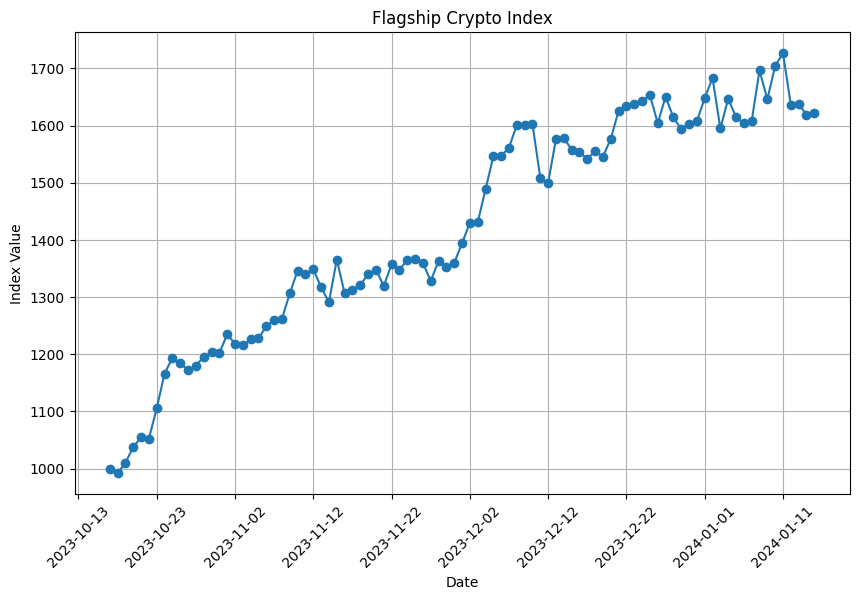

In [71]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime


def plot_daily_indices(daily_indices):
    # Extract dates and index values
    #dates = list(daily_indices.keys())
    indices = list(daily_indices.values())
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in daily_indices.keys()]


    # Create a line plot
    plt.figure(figsize=(10, 6))
    plt.plot(dates, indices, marker='o', linestyle='-')
    plt.title('Flagship Crypto Index')
    plt.xlabel('Date')
    plt.ylabel('Index Value')

    # Set x-axis to show only every 10th date
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.xticks(rotation=45)
    plt.grid(True)

    plt.show()

plot_daily_indices(daily_indices)
